# Neural Network Implementation: without Dropout

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


-----

## Read in the data:

In [2]:
# Read h5 file and format as a Pandas data frame
def read_h5_file(filename):
#     filename = 'test.h5'
    f = h5py.File(filename, 'r')
    data = [v for r in list(f['data']) for v in r]
    label = [v for r in list(f['label']) for v in r]
    return pd.DataFrame({'data': data, 'label': label})

In [3]:
train = read_h5_file('co2_train.h5')
test = read_h5_file('co2_test.h5')
# train = read_h5_file('solar_train.h5')
# test = read_h5_file('solar_test.h5')

In [7]:
test.head()

,data,label
0,1.725695,2.192245
1,1.727695,2.192245
2,1.729695,2.192245
3,1.731695,2.192245
4,1.733695,2.192245


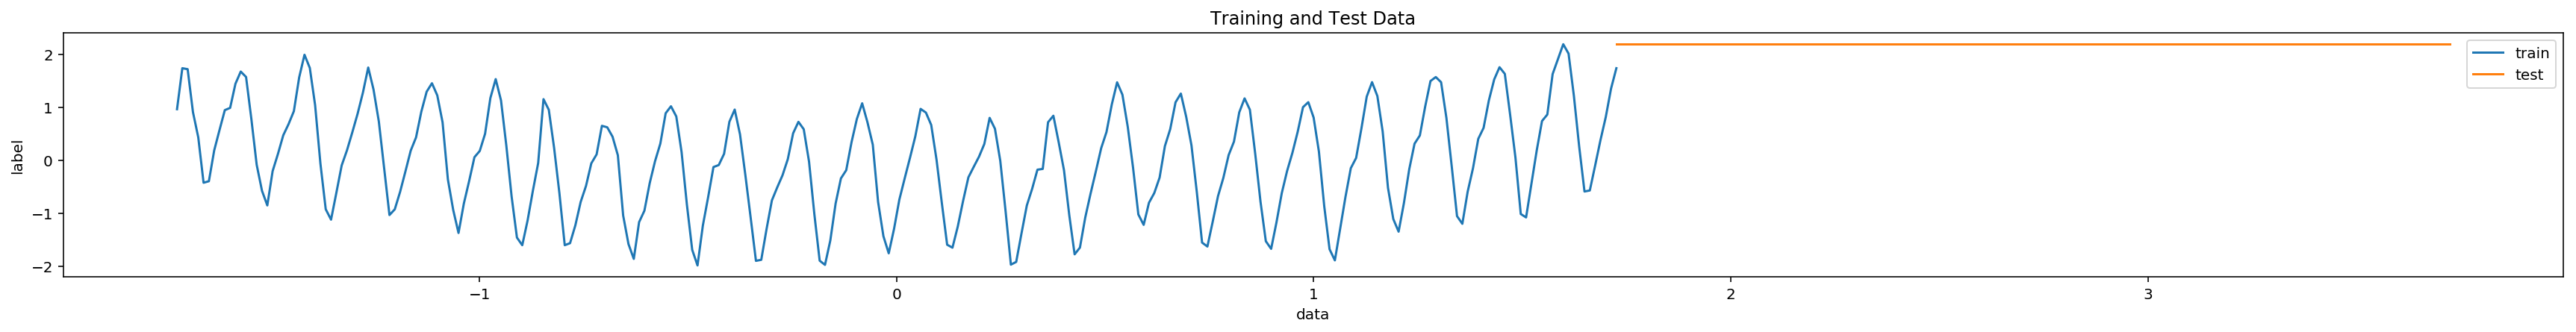

In [14]:
# Plot Training and Test Data
plt.figure(figsize=(30,3))
plt.plot(train['data'], train['label'], label='train')
plt.plot(test['data'], test['label'], label='test')
plt.xlabel('data')
plt.ylabel('label')
plt.title('Training and Test Data')
plt.legend()
plt.show()

In [15]:
len(train)

272

In [16]:
# Fit model according to specification in paper
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD
import keras.backend as K
from keras.callbacks import Callback
from keras.callbacks import LearningRateScheduler

full = train.append(test)

# Euclidean loss function--obtained from:
# http://www.riptutorial.com/keras/example/32022/euclidean-distance-loss
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

# Implement learning rate schedule
# Adapted from examples at https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
def learning_schedule(epoch):
    base_lrate = 5e-3
    gamma = 0.0001
    p = 0.25
    lrate = base_lrate * (1 + gamma*272*epoch)**(-p)
    return lrate

# Based off of examples from:
# 1. https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
# 2. https://keras.io/getting-started/sequential-model-guide/#compilation

# Create NN dropout model
def create_model():
    # Create model
    model = Sequential()
    # Layer 1
    model.add(Dense(1024, input_dim=1, kernel_initializer='lecun_uniform', activation='relu'))
   
    # Layer 2
    model.add(Dense(1024, kernel_initializer='lecun_uniform',
                    activation='relu', use_bias=False))
   
    # Layer 3
    model.add(Dense(1024, kernel_initializer='lecun_uniform',
                    activation='relu', use_bias=False))
   
    # Layer 4
    model.add(Dense(1024, kernel_initializer='lecun_uniform',
                    activation='relu', use_bias=False))
    # Layer 5
    model.add(Dense(1, kernel_initializer='lecun_uniform'))
    
    # Compile model
    sgd = SGD(lr=5e-3, momentum=0.9, decay=5e-7, nesterov=False)
    model.compile(loss=euclidean_distance_loss, optimizer=sgd)
    return model

# Save predictions from every epoch
# Code from: https://stackoverflow.com/questions/36895627/python-keras-creating-a-callback-with-one-prediction-for-each-epoch?noredirect=1&lq=1
class prediction_history(Callback):
    def __init__(self):
        self.predhis = []
    def on_epoch_end(self, epoch, logs={}):
        self.predhis.append(model.predict(full['data']))

In [17]:
# Train the model, iterating on the data in batches of 32 
nepochs = 100
model = create_model()
# model.fit(x=train['data'], y=train['label'], epochs=1000, batch_size=32)

#Calling the subclass
predictions=prediction_history()

#Executing the model.fit of the neural network
lrate = LearningRateScheduler(learning_schedule)
callbacks_list = [predictions, lrate]
#callbacks_list = [predictions]
model.fit(x=train['data'], y=train['label'], epochs=nepochs, batch_size=1, callbacks=callbacks_list)


Epoch 1/100
272/272 [==============================] - 4s 13ms/step - loss: 0.9647
Epoch 2/100
272/272 [==============================] - 3s 13ms/step - loss: 0.8643
Epoch 3/100
272/272 [==============================] - 4s 13ms/step - loss: 0.8571
Epoch 4/100
272/272 [==============================] - 3s 12ms/step - loss: 0.8601
Epoch 5/100
272/272 [==============================] - 3s 12ms/step - loss: 0.8504
Epoch 6/100
272/272 [==============================] - 3s 12ms/step - loss: 0.8524
Epoch 7/100
272/272 [==============================] - 3s 13ms/step - loss: 0.8591
Epoch 8/100
272/272 [==============================] - 3s 12ms/step - loss: 0.8603
Epoch 9/100
272/272 [==============================] - 3s 13ms/step - loss: 0.8456
Epoch 10/100
272/272 [==============================] - 3s 12ms/step - loss: 0.8550
Epoch 11/100
272/272 [==============================] - 3s 12ms/step - loss: 0.8534
Epoch 12/100
272/272 [==============================] - 3s 13ms/step - loss: 0.8573
E

In [18]:
full['pred'] = model.predict(full['data'])
test_preds = model.predict(test['data'])

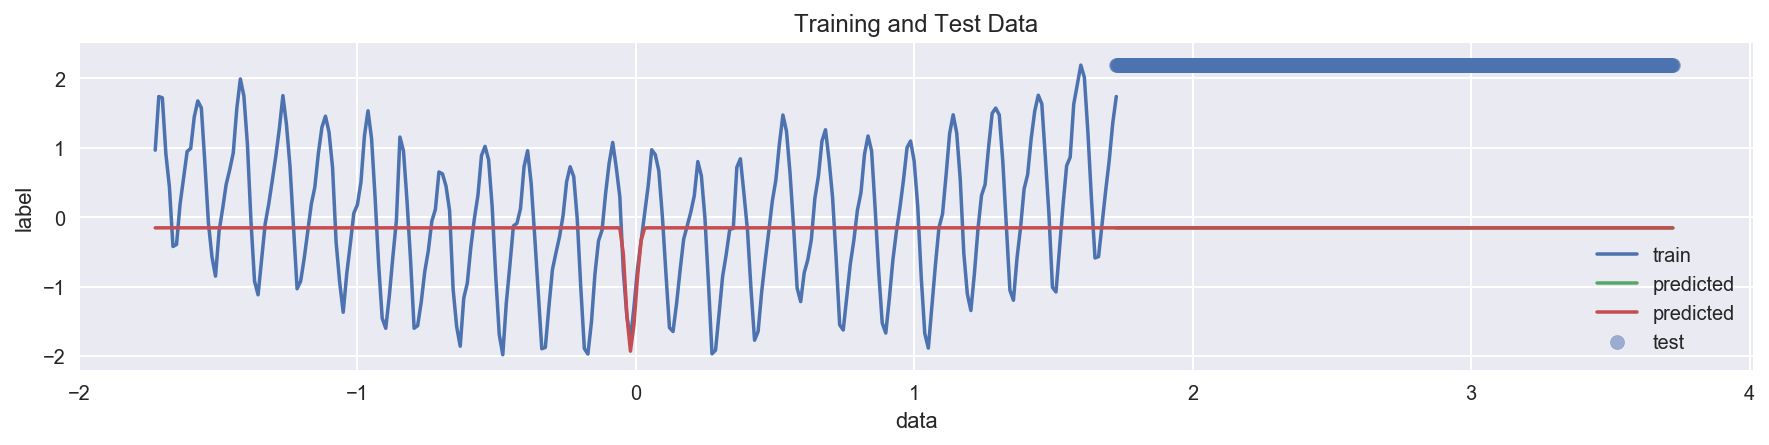

In [20]:
plt.style.use('seaborn')
plt.figure(figsize=(15, 3))
plt.plot(train['data'], train['label'], label='train')
plt.scatter(test['data'], test['label'], label='test', alpha = 0.5)
plt.plot(test['data'], test_preds, label='predicted')
plt.plot(full['data'], full['pred'], label='predicted')
plt.xlabel('data')
plt.ylabel('label')
plt.title('Training and Test Data')
plt.legend()
plt.show()